In [31]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image
import tensorflow.compat.v1 as tf
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
import random
import tensorflow_hub as hub
import time

from tensorflow.keras.applications.efficientnet import EfficientNetB0 as Net
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [32]:
def get_data(limit: int = None, dir: str = './roboflow/'):
    train, valid, test = list(), list(), list()

    for path, dirs, files in os.walk(dir):
        if not 'scissors' in path and not 'rock' in path and not 'paper' in path:
            continue

        for name in files:
            file_name = os.path.join(path, name)

            if 'train' in path:
                train.append(file_name)
            elif 'valid' in path:
                valid.append(file_name)
            elif 'test' in path:
                test.append(file_name)

    if limit:
        train = random.sample(train, limit)
        valid = random.sample(valid, limit)
        test = random.sample(test, limit)

    return train, valid, test


In [33]:
def gen_plt(history=None, is_v2: bool = False):
    if is_v2:
        title = 'EfficientNetV2'
        keys = ['accuracy', 'val_accuracy']
    else:
        title = 'EfficientNetV1'
        keys = ['acc', 'val_acc']

    acc = history.history[keys[0]]
    val_acc = history.history[keys[1]]
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_x = range(len(acc))

    plt.plot(epochs_x, acc, 'bo', label='Training acc')
    plt.plot(epochs_x, val_acc, 'b', label='Validation acc')
    plt.title(f'{title} Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs_x, loss, 'bo', label='Training loss')
    plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
    plt.title(f'{title} Training and validation loss')
    plt.legend()

    return plt

In [34]:
def predict_image(
        model, width: int = 150, height: int = 150, img: str = None, indices: tuple = None):
    lookup = dict((y, x) for x, y in indices.items())
    img = image.load_img(img, target_size=(width, height))
    x = image.img_to_array(img)
    x = x.reshape((1,) + x.shape)
    x /= 255.0

    # print(indices)
    # print(lookup)
    # print(model.predict([x]))

    return lookup[np.argmax(model.predict([x]), axis=1)[0]]

In [35]:
train_data, valid_data, test_data = get_data()

width, height = 150, 150
input_shape = (height, width, 3)

batch_size = 10
epochs = 100
dropout = 0.2

NUM_TRAIN = sum([len(files) for r, d, files in os.walk('./roboflow/train/')])
NUM_TEST = sum([len(files) for r, d, files in os.walk('./roboflow/test/')])


In [36]:
train_gen = ImageDataGenerator(rescale=1.0 / 255)
test_gen = ImageDataGenerator(rescale=1.0 / 255)

train = train_gen.flow_from_directory(
    './roboflow/train',
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='categorical',
)

valid = test_gen.flow_from_directory(
    './roboflow/valid',
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='categorical',
)

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


In [37]:
conv_base = Net(weights='imagenet', include_top=False, input_shape=input_shape)
conv_base.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 150, 150, 3)  0           ['input_6[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 150, 150, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 150, 150, 3)  0           ['normalization[0][0

In [38]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D(name='gap'))
if dropout > 0:
    model.add(layers.Dropout(dropout, name='dropout_out'))
model.add(layers.Dense(3, activation='softmax', name='fc_out'))

conv_base.trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 5, 5, 1280)       4049571   
                                                                 
 gap (GlobalMaxPooling2D)    (None, 1280)              0         
                                                                 
 dropout_out (Dropout)       (None, 1280)              0         
                                                                 
 fc_out (Dense)              (None, 3)                 3843      
                                                                 
Total params: 4,053,414
Trainable params: 3,843
Non-trainable params: 4,049,571
_________________________________________________________________


In [39]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.RMSprop(lr=2e-5),
    metrics=['acc'],
)

start = time.time()
history = model.fit_generator(
    train,
    steps_per_epoch=NUM_TRAIN // batch_size,
    epochs=epochs,
    validation_data=valid,
    validation_steps=NUM_TEST // batch_size,
    verbose=1,
    use_multiprocessing=True,
    workers=os.cpu_count(),
)

print(f'Elasped time for EfficientNetV1 : {time.time() - start:.4f} sec')

Epoch 1/100


/tmp/ipykernel_417543/4285278927.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(
2023-09-19 12:53:10.632304: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


245/252 [============================>.] - ETA: 0s - loss: 2.1283 - acc: 0.3359

2023-09-19 12:53:16.296696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


252/252 [==============================] - 9s 21ms/step - loss: 2.1133 - acc: 0.3377 - val_loss: 1.6555 - val_acc: 0.3000
Epoch 2/100
252/252 [==============================] - 6s 20ms/step - loss: 1.9940 - acc: 0.3313 - val_loss: 1.2678 - val_acc: 0.3000
Epoch 3/100
252/252 [==============================] - 6s 19ms/step - loss: 1.8701 - acc: 0.3433 - val_loss: 1.0958 - val_acc: 0.5333
Epoch 4/100
252/252 [==============================] - 6s 17ms/step - loss: 1.8294 - acc: 0.3270 - val_loss: 1.6797 - val_acc: 0.2000
Epoch 5/100
252/252 [==============================] - 6s 18ms/step - loss: 1.8178 - acc: 0.3310 - val_loss: 1.0918 - val_acc: 0.3667
Epoch 6/100
252/252 [==============================] - 6s 18ms/step - loss: 1.7687 - acc: 0.3492 - val_loss: 1.1309 - val_acc: 0.4000
Epoch 7/100
252/252 [==============================] - 6s 19ms/step - loss: 1.7466 - acc: 0.3337 - val_loss: 1.4504 - val_acc: 0.3000
Epoch 8/100
252/252 [==============================] - 6s 19ms/step - loss

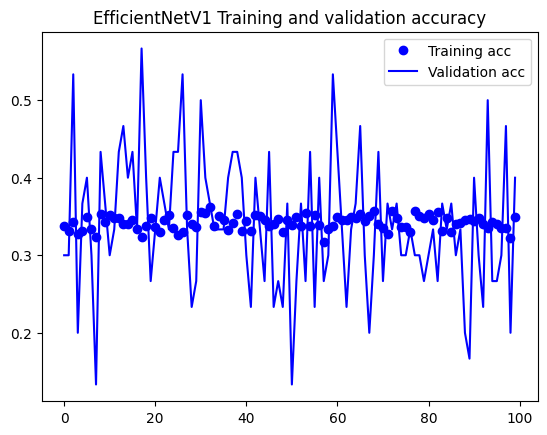

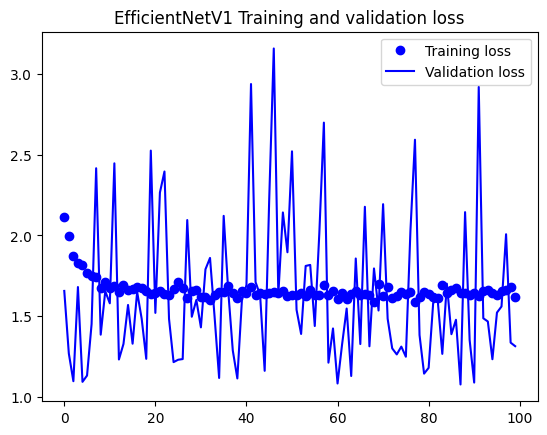

In [40]:
gen_plt(history).show()

In [41]:
tf.keras.backend.clear_session()
sys.path.append('./automl/efficientnetv2/')

In [42]:
print(width, height)

150 150


In [43]:
import effnetv2_model

ev2 = effnetv2_model.EffNetV2Model(model_name='efficientnetv2-s', include_top=False)
ev2.build(input_shape=(None, width, height, 3))
ev2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 stem (Stem)                 (None, 112, 112, 24)      744       
                                                                 
 blocks_0 (FusedMBConvBlock)  (None, 112, 112, 24)     5280      
                                                                 
 blocks_1 (FusedMBConvBlock)  (None, 112, 112, 24)     5280      
                                                                 
 blocks_2 (FusedMBConvBlock)  (None, 56, 56, 48)       25920     
                                                                 
 blocks_3 (FusedMBConvBlock)  (None, 56, 56, 48)       93120     
                                                                 
 blocks_4 (FusedMBConvBlock)  (None, 56, 56, 48)       93120 

In [44]:
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=[width, height, 3]),
    effnetv2_model.EffNetV2Model(
        model_name='efficientnetv2-s', include_top=False),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(
        3, kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])

model.build((None, width, height, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (EffNetV2M  (None, 1280)             20331360  
 odel)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 20,335,203
Trainable params: 20,181,331
Non-trainable params: 153,872
_________________________________________________________________


In [45]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9),
    loss=tf.keras.losses.CategoricalCrossentropy(
        from_logits=True, label_smoothing=0.1),
    metrics=['accuracy'])

start = time.time()
history = model.fit(
    train,
    steps_per_epoch=NUM_TRAIN // batch_size,
    epochs=epochs,
    validation_data=valid,
    validation_steps=NUM_TEST // batch_size,
    verbose=1,
    use_multiprocessing=True,
    workers=os.cpu_count(),
)
print(f'Elapsed time for EfficientNetV2 : {time.time() - start:.4f} sec')

Epoch 1/100


2023-09-19 13:06:18.303740: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


252/252 [==============================] - ETA: 0s - loss: 1.1430 - accuracy: 0.4667

2023-09-19 13:06:41.579054: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


252/252 [==============================] - 26s 66ms/step - loss: 1.1430 - accuracy: 0.4667 - val_loss: 2.6390 - val_accuracy: 0.5000
Epoch 2/100
252/252 [==============================] - 17s 62ms/step - loss: 0.5224 - accuracy: 0.9004 - val_loss: 0.6828 - val_accuracy: 0.8667
Epoch 3/100
104/252 [===========>..................] - ETA: 6s - loss: 0.4073 - accuracy: 0.9606

252/252 [==============================] - 17s 61ms/step - loss: 0.3930 - accuracy: 0.9671 - val_loss: 0.6039 - val_accuracy: 0.8667
Epoch 4/100
252/252 [==============================] - 16s 56ms/step - loss: 0.3672 - accuracy: 0.9881 - val_loss: 0.5953 - val_accuracy: 0.8333
Epoch 5/100
252/252 [==============================] - 16s 59ms/step - loss: 0.3519 - accuracy: 0.9925 - val_loss: 0.9481 - val_accuracy: 0.7333
Epoch 6/100
252/252 [==============================] - 16s 59ms/step - loss: 0.3422 - accuracy: 0.9956 - val_loss: 0.6280 - val_accuracy: 0.8667
Epoch 7/100
252/252 [==============================] - 17s 59ms/step - loss: 0.3302 - accuracy: 0.9996 - val_loss: 0.7500 - val_accuracy: 0.8333
Epoch 8/100
252/252 [==============================] - 17s 60ms/step - loss: 0.3367 - accuracy: 0.9952 - val_loss: 0.3548 - val_accuracy: 1.0000
Epoch 9/100
252/252 [==============================] - 16s 59ms/step - loss: 0.3274 - accuracy: 0.9992 - val_loss: 0.5134 - val_accuracy: 0.86

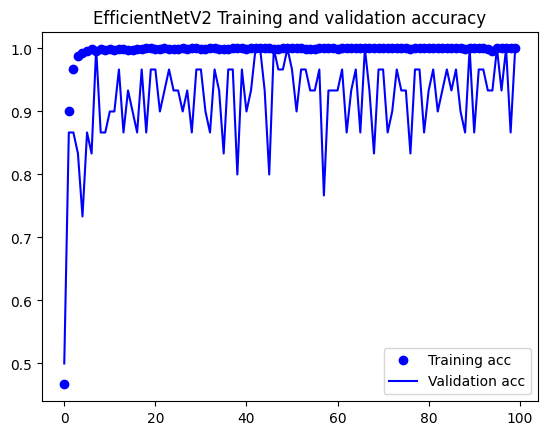

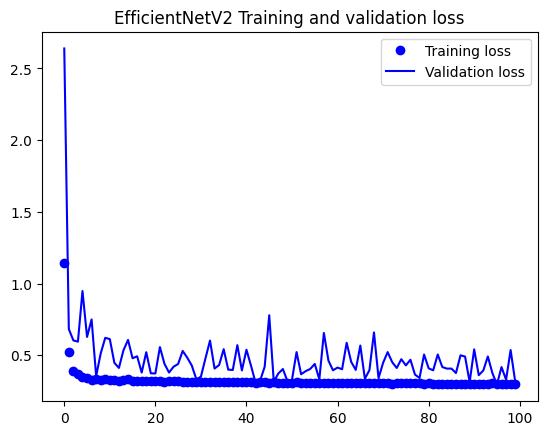

In [46]:
gen_plt(history, True).show()